# Cars4You ML Project Price Prediction
---
**Group 2:**

- Luis Mendes 20221949
- Margarida Mourives 20221809
- Simon Sazonov 20221689 
- Veronica Mendes 20221945
---

### **Abstract**

This project aims to develop a machine learning model for **Cars4You**, an online car resale platform, to predict car prices without requiring mechanic evaluations. The goal is to streamline the valuation process and reduce inspection delays.  

The dataset was cleaned and preprocessed by correcting inconsistencies, handling missing values, simplifying categories, encoding categorical variables, and scaling numerical features with **RobustScaler**. Missing values were imputed using a **KNN Imputer**, and feature selection through **RFE** and **Lasso Regression** confirmed that all features contribute meaningful information.  

A **Linear Regression** model was established as a benchmark (**MAE £3,440**), while a **Random Forest** achieved superior performance (**MAE £2,361**) with minimal overfitting. Finally, a fully automated **prediction pipeline** was built to preprocess the test data and generate `.csv` outputs for Kaggle submission. The Random Forest model, trained on the complete dataset, provides accurate and efficient price predictions, enhancing Cars4You’s operational efficiency.  

<a class="anchor" id='toc'></a> 
<div class="alert alert-block alert-info">

## **Index**<br>

[**Imports**](#0-bullet)<br>

[**Data Integration**](#1-bullet)<br>

[**Data Exploration & Initial Preprocessing**](#2-bullet)<br>
- [**Conclusions**](#21-bullet)<br>

[**Data Preparation:**](#3-bullet)<br>
- [**Outliers**](#31-bullet)<br>
- [**Spliting**](#32-bullet)<br>
- [**Imputation**](#33-bullet)<br>
    - [Categorical Fetures Imputation](#331-bullet)<br>
    - [Encoding](#332-bullet)<br>
    - [Numerical Fetures Imputation](#333-bullet)<br>
        - [Scaling](#3331-bullet)<br>
        - [KNN Imputer](#3332-bullet)<br>
- [**Feature Selection**](#34-bullet)<br>
    - [RFE](#341-bullet)<br>
    - [Lasso](#342-bullet)<br>
    - [Conclusion](#343-bullet)<br>

[**Modeling:**](#4-bullet)<br>
- [**Benchmark**](#41-bullet)<br>
- [**Random Forest**](#42-bullet)<br>
- [**Final Model**](#43-bullet)<br>

[**Deployment:**](#5-bullet)<br>
- [**Test Set**](#51-bullet)<br>
- [**Pipeline Test Set**](#52-bullet)<br>
- [**Prediction**](#53-bullet)<br>

    
</div>


# Identifying Business Needs

Cars 4 You is an online car resale platform that connects users looking to sell their vehicles with potential buyers across multiple brands. The company’s business model relies on an internal evaluation process in which submitted cars are physically inspected by certified mechanics to determine a fair purchase price before resale. While this approach has ensured high customer satisfaction and trust, the company’s rapid growth has resulted in longer waiting times for vehicle inspections, leading to customer attrition and loss of market share to competitors.

To address this challenge, this project aims to develop a machine learning–based predictive model capable of accurately estimating a car’s market value based solely on user-provided details, such as brand, model, year, mileage, fuel type, and condition. By leveraging historical sales and inspection data, the model will learn the underlying relationships between car attributes and their evaluated prices.

In more detail, the project will begin by exploring and understanding the dataset—identifying missing values, analyzing feature distributions, and investigating potential patterns or correlations with the target variable (car price). We opted for a Hold-out validation approach to train and evaluate our model, meaning that 80% of the data (randomly shuffled) will be used for training, while the remaining 20% will be reserved for testing performance.

Before modeling, the data will be carefully cleaned by resolving inconsistencies, treating outliers, encoding categorical variables, scaling numerical features, imputing missing values, and selecting the most important predictors for the target variable. Throughout this process, we will ensure that the imputer, scaler, and model are trained exclusively on the training set, without exposure to the validation or test data, to prevent data leakage.

Next, we will proceed to the modeling phase, starting with simpler algorithms to establish baseline performance. These benchmark models, such as Linear Regression, will be compared using metrics like Mean Absolute Error (MAE), which was chosen because it aligns with Kaggle’s evaluation standard competition and provides a more interpretable measure of prediction accuracy without overly penalizing outliers.

Finally, the same preprocessing steps will be applied to the test set, allowing us to evaluate the best-performing model on unseen data and generate final predictions for car prices.

The outcome of this project will enable Cars 4 You to automate the preliminary valuation process, reduce dependency on manual inspections, and deliver instant, data-driven price estimates to users. This solution will streamline operations, enhance customer experience, and provide the company with a competitive edge in the online car resale market.

<a class="anchor" id="0-bullet">    </a>
# Imports
[Back to Index](#toc)

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# data partition
from sklearn.model_selection import train_test_split, KFold
# Scaling
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
# Imputation
from sklearn.impute import KNNImputer
# Feature Selection
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso
# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
# Evaluation Metrics
from sklearn.metrics import mean_absolute_error
# Grid Search
from sklearn.model_selection import ParameterGrid
# Progress
from tqdm import tqdm
# CV Score(falta grafico real/predicted)
from utils import avg_scores, RFM_Feature_visualization


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

sns.set_context("notebook")
sns.set_style("ticks")

<a class="anchor" id="1-bullet">    </a>
# Data Integration
[Back to Index](#toc)

| **Attribute**      | **Description** |
|---------------------|-----------------|
| **carID**           | Unique identifier assigned to each car. |
| **Brand**           | The car’s main brand (e.g., Ford, Toyota). |
| **model**           | The specific model of the car. |
| **year**            | The year of registration of the car. |
| **mileage**         | The total reported distance travelled by the car (in miles). |
| **tax**             | The amount of road tax (in £) applicable to the car in 2020. |
| **transmission**    | Type of transmission used by the car (e.g., Manual, Automatic, Semi-Automatic). |
| **fuelType**        | Type of fuel used by the car (e.g., Diesel, Petrol, Hybrid, Electric). |
| **mpg**             | Average miles per gallon (fuel efficiency). |
| **engineSize**      | Engine size in liters (cubic decimeters). |
| **paintQuality%**   | Mechanic’s assessment of the car’s paint quality and hull integrity (recorded during evaluation). |
| **previousOwners**  | Number of previously registered owners of the vehicle. |
| **hasDamage**       | Boolean flag provided by the seller indicating whether the car is damaged. |
| **price**           | The car’s purchase price paid by Cars 4 You (in £). |

In [2]:
df_cars4you_train = pd.read_csv('../project_data/train.csv')

df_cars4you_test = pd.read_csv('../project_data/test.csv')

<a class="anchor" id="2-bullet">    </a>
# Data Exploration & Initial Preprocessing
[Back to Index](#toc)

In [3]:
df_cars4you_train.head()

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
1,53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
2,6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
3,29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
4,10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0


In [4]:
df_cars4you_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   Brand           74452 non-null  object 
 2   model           74456 non-null  object 
 3   year            74482 non-null  float64
 4   price           75973 non-null  int64  
 5   transmission    74451 non-null  object 
 6   mileage         74510 non-null  float64
 7   fuelType        74462 non-null  object 
 8   tax             68069 non-null  float64
 9   mpg             68047 non-null  float64
 10  engineSize      74457 non-null  float64
 11  paintQuality%   74449 non-null  float64
 12  previousOwners  74423 non-null  float64
 13  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(2), object(4)
memory usage: 8.1+ MB


In [5]:
df_cars4you_train.isnull().sum()

carID                0
Brand             1521
model             1517
year              1491
price                0
transmission      1522
mileage           1463
fuelType          1511
tax               7904
mpg               7926
engineSize        1516
paintQuality%     1524
previousOwners    1550
hasDamage         1548
dtype: int64

In [6]:
df_cars4you_train.duplicated(subset='carID').sum()

np.int64(0)

We have information on 75,973 cars, each identified by a unique carID and a price, which serves as a distinct identifier and can be used as the dataset’s index column.

An initial exploration of the dataset revealed some formatting inconsistencies. In particular, the variables previousOwners and year should be represented as integers rather than strings or mixed data types. These inconsistencies will be addressed in the data-cleaning stage to ensure accurate analysis and modeling.

Additionally, several attributes contain missing values. While carID and price are complete, other variables show varying degrees of missingness. Specifically, Brand (1,521 missing, 2.00%), model (1,517, 2.00%), year (1,491, 1.96%), transmission (1,522, 2.00%), mileage (1,463, 1.93%), fuelType (1,511, 1.99%), tax (7,904, 10.40%), mpg (7,926, 10.43%), engineSize (1,516, 2.00%), paintQuality% (1,524, 2.01%), previousOwners (1,550, 2.04%), and hasDamage (1,548, 2.04%) have missing entries.

Overall, most variables contain a relatively small proportion of missing data (around 2%), except for tax and mpg, which have over 10% missing values. These higher missing rates will require special attention during preprocessing, likely through imputation.

Another important point is that, since our goal is to build a model that operates without the assistance of a mechanic, we cannot include the variable **paintQuality%**, as it is only available after a manual inspection. Therefore, this variable will be removed from the dataset.

In [7]:
df_cars4you_train.set_index('carID', inplace=True)
df_cars4you_train.drop('paintQuality%', inplace=True ,axis=1)

In [8]:
df_cars4you_train.describe().T

,count,mean,std,min,25%,50%,75%,max
year,74482.0,2017.096611,2.208704,1970.000000,2016.00,2017.0,2019.0,2024.121759
price,75973.0,16881.889553,9736.926322,450.000000,10200.00,14699.0,20950.0,159999.000000
mileage,74510.0,23004.184088,22129.788366,-58540.574478,7423.25,17300.0,32427.5,323000.000000
tax,68069.0,120.329078,65.521176,-91.121630,125.00,145.0,145.0,580.000000
mpg,68047.0,55.152666,16.497837,-43.421768,46.30,54.3,62.8,470.800000
engineSize,74457.0,1.660136,0.573462,-0.103493,1.20,1.6,2.0,6.600000
previousOwners,74423.0,1.994580,1.472981,-2.345650,1.00,2.0,3.0,6.258371
hasDamage,74425.0,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.000000


The hasDamage variable showed no variability, as all its values were 0. Since it does not provide any useful information for the model, we will remove it from the dataset.

In [9]:
df_cars4you_train.drop('hasDamage', inplace=True ,axis=1)

In [10]:
df_cars4you_train.describe(include='O').T

,count,unique,top,freq
Brand,74452,72,Ford,14808
model,74456,735,Focus,6353
transmission,74451,40,Manual,38050
fuelType,74462,34,Petrol,37995


In [11]:
categorical_columns = ['Brand',
                       'model',
                       'transmission',
                       'fuelType']

numerical_columns = ['year',
                     'mileage',
                     'tax',
                     'mpg',
                     'engineSize',
                     'previousOwners',
                     'price']

In [12]:
for feature in categorical_columns:
    print(f'Unique values in {feature}:')
    print(df_cars4you_train[feature].unique())
    print('-----------------------------------')

Unique values in Brand:
['VW' 'Toyota' 'Audi' 'Ford' 'BMW' 'Skoda' 'Opel' 'Mercedes' 'FOR'
 'mercedes' 'Hyundai' 'w' 'ord' 'MW' 'bmw' nan 'yundai' 'BM' 'Toyot' 'udi'
 'Ope' 'AUDI' 'V' 'opel' 'pel' 'For' 'pe' 'Mercede' 'audi' 'MERCEDES'
 'OPEL' 'koda' 'FORD' 'Hyunda' 'W' 'Aud' 'vw' 'hyundai' 'skoda' 'ford'
 'TOYOTA' 'ercedes' 'oyota' 'toyota' 'SKODA' 'Skod' 'HYUNDAI' 'kod' 'v'
 'for' 'SKOD' 'aud' 'KODA' 'PEL' 'yunda' 'or' 'UDI' 'OYOTA' 'HYUNDA' 'mw'
 'OPE' 'mercede' 'ERCEDES' 'ercede' 'TOYOT' 'MERCEDE' 'ORD' 'ud' 'ope'
 'AUD' 'hyunda' 'skod' 'toyot']
-----------------------------------
Unique values in model:
[' Golf' ' Yaris' ' Q2' ' FIESTA' ' 2 Series' '3 Series' ' A3' ' Octavia'
 ' Passat' ' Focus' ' Insignia' ' A Clas' ' Q3' ' Fabia' ' A Class' ' Ka+'
 ' 3 Series' ' GLC Class' ' I30' ' C Class' ' Polo' ' E Class' ' C Clas'
 ' Q5' ' Up' ' Fiesta' ' C-HR' ' Mokka X' ' Corsa' ' Astra' ' TT'
 ' 5 Series' ' Aygo' ' 4 Series' ' SLK' ' Viva' ' T-Roc' 'Focus'
 ' EcoSport' ' Tucson' ' EcoSpo

We identified an issue with the categorical variables, as they are inconsistently formatted. To ensure that each category is properly recognized as a unique class, we will clean these variables by removing extra white spaces and converting all text to lowercase. This preprocessing step should help reduce redundancy and improve the overall data quality.

In [13]:
df_cars4you_train = df_cars4you_train.applymap(lambda x: x.replace(" ", "").lower() if isinstance(x, str) else x)

In [14]:
for feature in categorical_columns:
    print(f'Unique values in {feature}:')
    print(df_cars4you_train[feature].unique())
    print('-----------------------------------')

Unique values in Brand:
['vw' 'toyota' 'audi' 'ford' 'bmw' 'skoda' 'opel' 'mercedes' 'for'
 'hyundai' 'w' 'ord' 'mw' nan 'yundai' 'bm' 'toyot' 'udi' 'ope' 'v' 'pel'
 'pe' 'mercede' 'koda' 'hyunda' 'aud' 'ercedes' 'oyota' 'skod' 'kod'
 'yunda' 'or' 'ercede' 'ud']
-----------------------------------
Unique values in model:
['golf' 'yaris' 'q2' 'fiesta' '2series' '3series' 'a3' 'octavia' 'passat'
 'focus' 'insignia' 'aclas' 'q3' 'fabia' 'aclass' 'ka+' 'glcclass' 'i30'
 'cclass' 'polo' 'eclass' 'cclas' 'q5' 'up' 'c-hr' 'mokkax' 'corsa'
 'astra' 'tt' '5series' 'aygo' '4series' 'slk' 'viva' 't-roc' 'ecosport'
 'tucson' 'ecospor' nan 'x-class' 'clclass' 'ix20' 'i20' 'rapid' 'a1'
 'auris' 'sharan' 'adam' 'x3' 'a8' 'glsclass' 'b-max' 'a4' 'kona' 'i10'
 'mokka' 's-max' 'x2' 'crosslandx' 'tiguan' 'a5' 'gleclass' 'zafira'
 'ioniq' 'a6' 'mondeo' 'yetioutdoor' 'x1' 'scala' 'sclass' '1series'
 'kamiq' 'kuga' 'tourneoconnect' 'q7' 'glaclass' 'arteon' 'slclass'
 'santafe' 'grandlandx' 'i800' 'rav4' 'to

This cleaning step actually improved the results. Next, we will group the categories of the Brand, transmission, and fuelType variables, manually as each contains only a limited number of unique values.

In [15]:
dict_brand_mapping = {'bmw' : ['bm','w','mw', 'm'],
                      'vw': ['v'],
                      'toyota': ['toyot', 'oyota', 'oyot'],
                      'audi': ['udi', 'aud', 'ud'],
                      'ford': ['ord', 'for', 'or'],
                      'skoda': ['koda', 'skod', 'kod'],
                      'opel': ['ope','pel','pe'],
                      'mercedes': ['mercede', 'ercedes', 'ercede'],
                      'hyundai': ['yundai', 'hyunda', 'yunda']}

# other are only 5 cars, so we will say that they are null
dict_transmission_mapping = {'semi-auto':['semi-aut','emi-auto','emi-aut'],
                      'manual': ['anual','manua','anua'],
                      'NAN' : ['unknown', 'unknow', 'nknown', 'nknow', 'other'],
                      'automatic': ['automati','utomati','utomatic']}

dict_fuelType_mapping = {
    'petrol': ['etrol', 'petro', 'etro'],
    'diesel': ['iesel', 'diese', 'iese'],
    'hybrid': ['ybri', 'hybri', 'ybrid'],
    'other': ['ther', 'othe']
}


In [16]:
for keys, values in dict_brand_mapping.items():
    df_cars4you_train.loc[df_cars4you_train['Brand'].isin(values), 'Brand'] = keys

for keys, values in dict_transmission_mapping.items():
    df_cars4you_train.loc[df_cars4you_train['transmission'].isin(values), 'transmission'] = keys if keys != 'NAN' else np.nan

for keys, values in dict_fuelType_mapping.items():
    df_cars4you_train.loc[df_cars4you_train['fuelType'].isin(values), 'fuelType'] = keys

# removing 'model' from categorical columns as it has too many unique values
# we wont do visualization with that
categorical_columns.pop(1) 

'model'

In [17]:
for feature in categorical_columns:
    print(f'Unique values in {feature}:')
    print(df_cars4you_train[feature].unique())
    print('-----------------------------------')

Unique values in Brand:
['vw' 'toyota' 'audi' 'ford' 'bmw' 'skoda' 'opel' 'mercedes' 'hyundai' nan]
-----------------------------------
Unique values in transmission:
['semi-auto' 'manual' 'automatic' nan]
-----------------------------------
Unique values in fuelType:
['petrol' 'diesel' 'hybrid' nan 'other' 'electric']
-----------------------------------


In [18]:
df_cars4you_train.describe(include='O').T

,count,unique,top,freq
Brand,74452,9,ford,16063
model,74456,296,focus,6775
transmission,73710,3,manual,41627
fuelType,74462,5,petrol,41181


Now we will do some visualizations on the categorical and numeric features

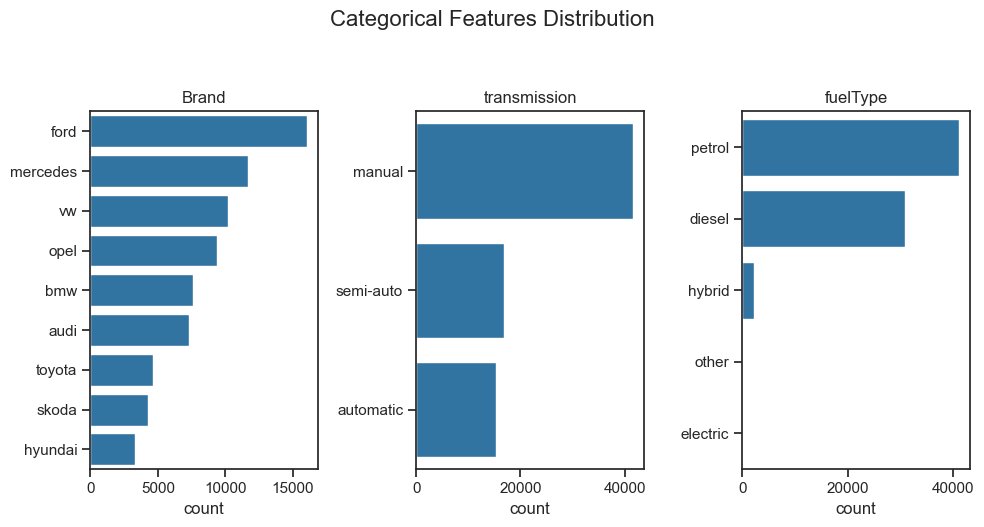

In [19]:
fig, axes= plt.subplots(1,3, figsize=(10,5))
axes = axes.flatten()
for i, column in enumerate(categorical_columns):
    order = df_cars4you_train[column].value_counts().index
    sns.countplot(y= column, data=df_cars4you_train, ax=axes[i], order=order)
    axes[i].set_title(column)
    axes[i].set_ylabel("")

plt.suptitle('Categorical Features Distribution', y=1.05, fontsize=16)
plt.tight_layout()
plt.show()

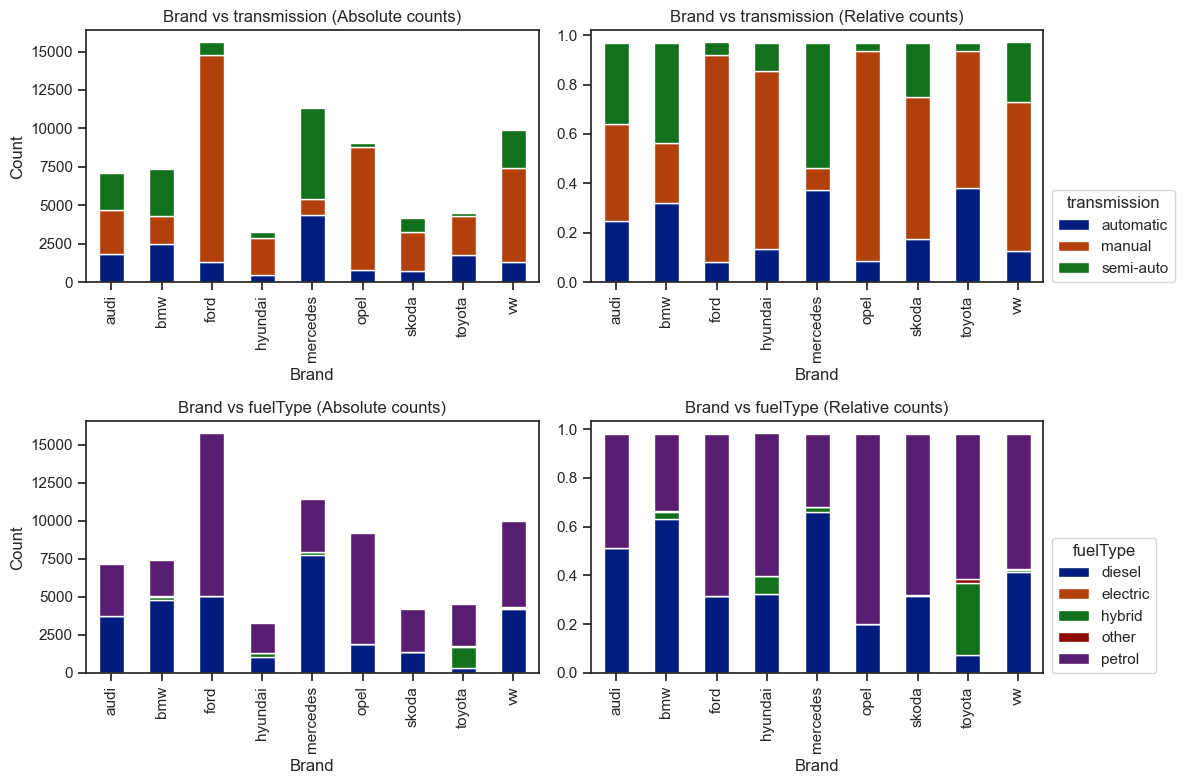

In [20]:
cat1 = 'Brand'

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

cat_list = ['transmission', 'fuelType']

for row_index in range(2):
    cat2 = cat_list[row_index]
    for column_index in range(2):

        if column_index == 0:
            catpc_df = df_cars4you_train.groupby([cat1, cat2])[cat2].size().unstack()
            catpc_df.plot.bar(stacked=True, ax=axes[row_index, column_index], color = sns.color_palette("dark"))
            axes[row_index, column_index].set_ylabel('Count')
            axes[row_index, column_index].legend([], frameon=False)
        
        else:
            catpc_df = df_cars4you_train.groupby([cat1, cat2])[cat2].size() / df_cars4you_train.groupby([cat1])[cat2].size()
            catpc_df.unstack().plot.bar(stacked=True, ax=axes[row_index, column_index], color = sns.color_palette("dark"))
            axes[row_index, column_index].legend(title=cat2, loc=(1.02, 0))
            
        axes[row_index, column_index].set_title(f'{cat1} vs {cat2} ({"Absolute" if column_index == 0 else "Relative"} counts)')
        axes[row_index, column_index].set_xlabel(cat1)
        

plt.tight_layout()
plt.show()

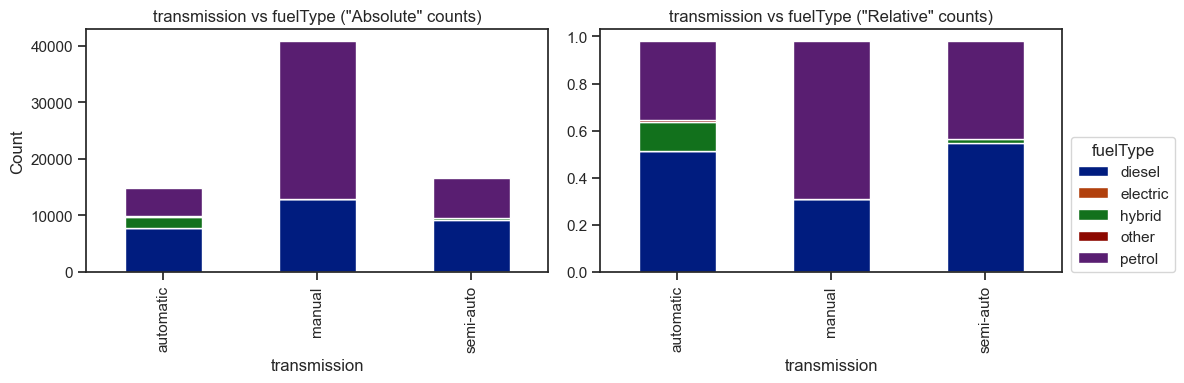

In [21]:
cat1 = 'transmission'

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cat2 = 'fuelType'

catpc_df = df_cars4you_train.groupby([cat1, cat2])[cat2].size().unstack()
catpc_df.plot.bar(stacked=True, ax=axes[0], color = sns.color_palette("dark"))
axes[0].set_ylabel('Count')
axes[0].legend([], frameon=False)
axes[0].set_title(f'{cat1} vs {cat2} ("Absolute" counts)')
axes[0].set_xlabel(cat1)

catpc_df = df_cars4you_train.groupby([cat1, cat2])[cat2].size() / df_cars4you_train.groupby([cat1])[cat2].size()
catpc_df.unstack().plot.bar(stacked=True, ax=axes[1], color = sns.color_palette("dark"))
axes[1].legend(title=cat2, loc=(1.02, 0))
axes[1].set_xlabel(cat1)
axes[1].set_title(f'{cat1} vs {cat2} ("Relative" counts)')

        

plt.tight_layout()
plt.show()

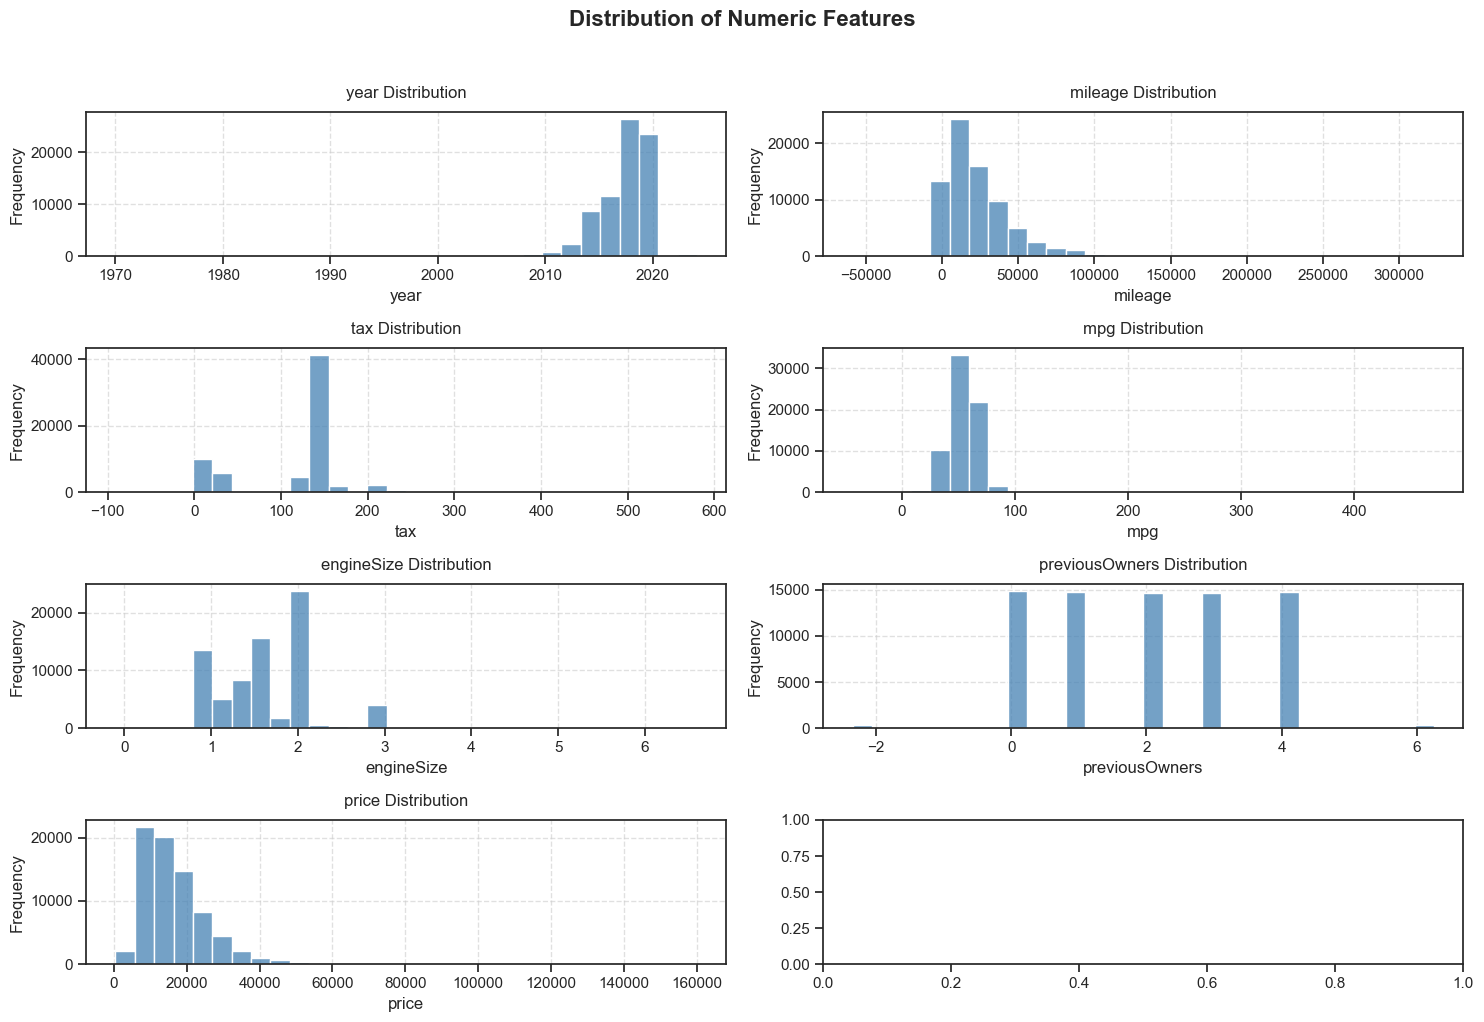

In [22]:
sp_rows = 4
sp_cols = 2

# Create the figure
fig, axes = plt.subplots(sp_rows, sp_cols, figsize=(15, 10))
axes = axes.flatten()

# --- Plot Each Feature ---
for i, feat in enumerate(numerical_columns):
    ax = axes[i]
    
    sns.histplot(df_cars4you_train[feat].dropna(), kde=False, ax=ax, bins=30, color="steelblue")
    ax.set_xlabel(feat)
    
    # Titles & formatting
    ax.set_title(f"{feat} Distribution", fontsize=12, pad=10)
    ax.set_ylabel("Frequency")
    ax.grid(True, linestyle='--', alpha=0.6)

# --- Layout & Global Title ---
plt.suptitle("Distribution of Numeric Features", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

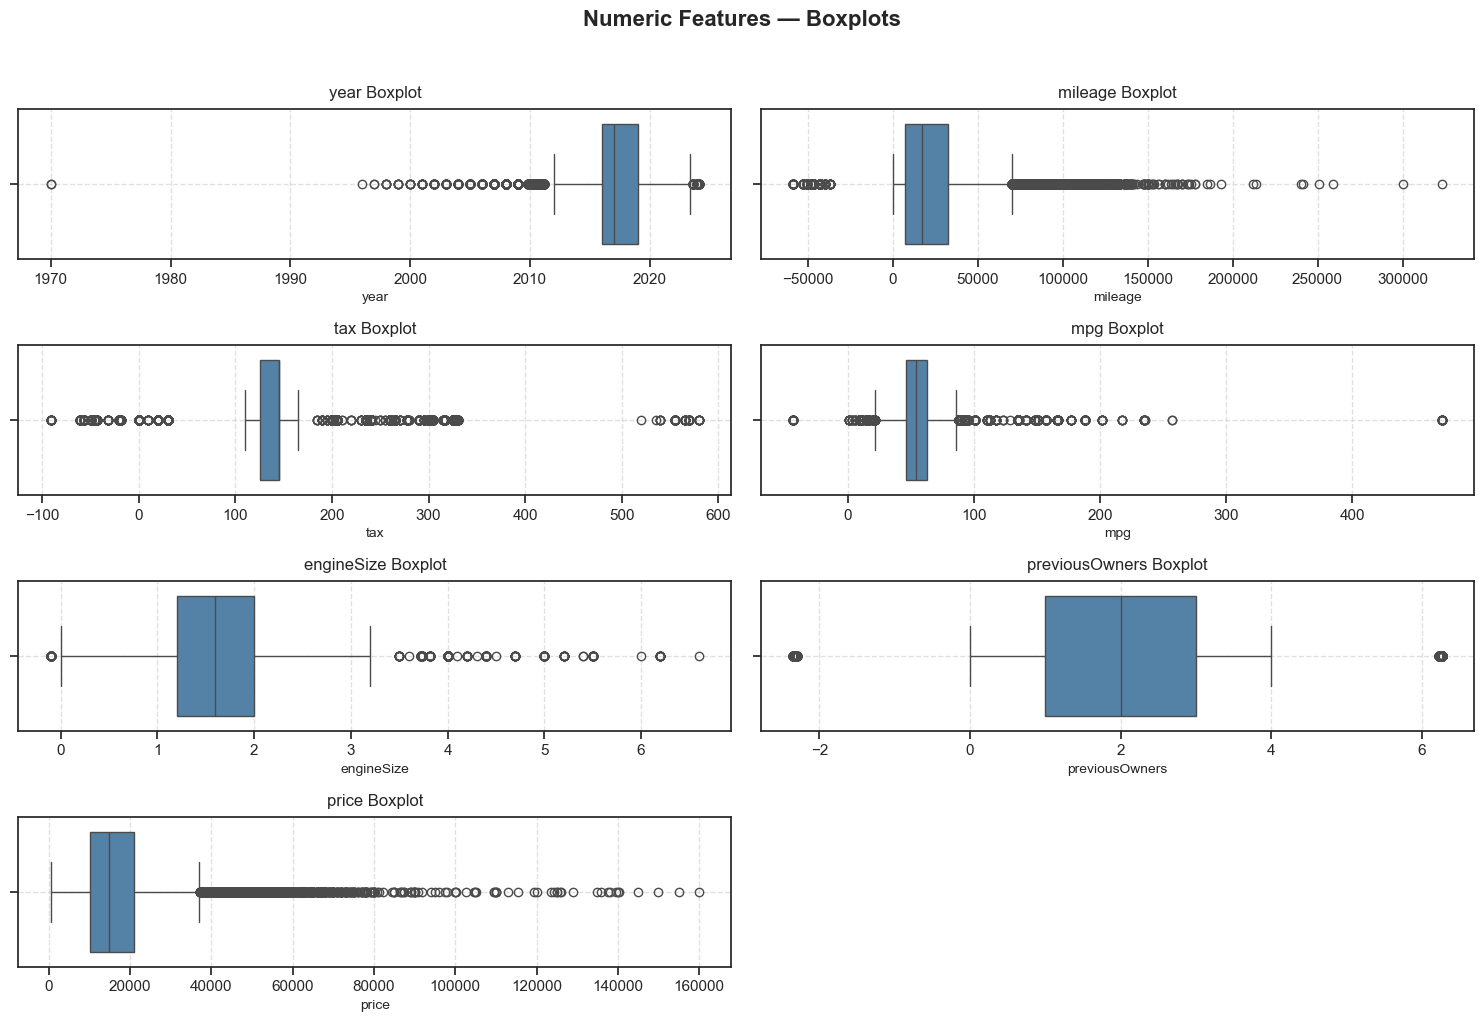

In [26]:
sp_rows = 4
sp_cols = 2

fig, axes = plt.subplots(
    sp_rows, sp_cols,
    figsize=(15, 10),
    tight_layout=True
)
axes = axes.flatten()

# --- Plot each feature ---
for i, feat in enumerate(numerical_columns):
    ax = axes[i]
    
    sns.boxplot(x=df_cars4you_train[feat].dropna(), ax=ax, color="steelblue")
    ax.set_xlabel(feat, fontsize=10)
    
    ax.set_title(f"{feat} Boxplot", fontsize=12, pad=8)
    ax.grid(True, linestyle='--', alpha=0.6)

# Hide any empty subplots (if number of features < grid slots)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Numeric Features — Boxplots", fontsize=16, fontweight='bold', y=1.02)
plt.show()

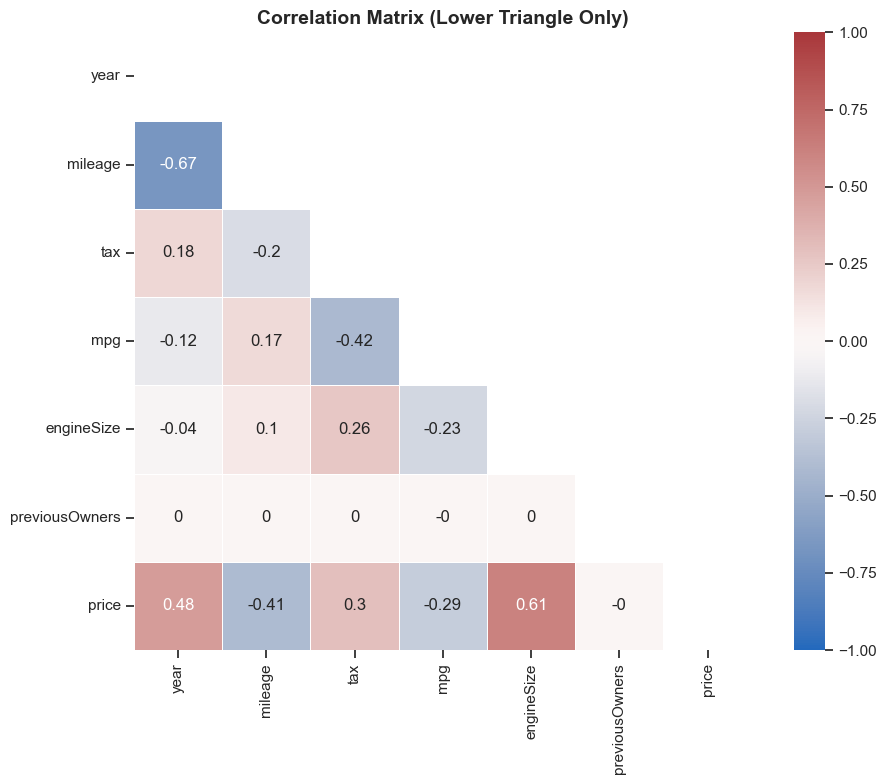

In [27]:
# Compute Pearson correlation
corr = df_cars4you_train[numerical_columns].corr(method="pearson")
# Round to 2 decimals for cleaner display
corr = corr.round(2)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

fig = plt.figure(figsize=(10, 8))

sns.heatmap(data=corr, 
            annot=True, 
            mask=mask, #aply the mask
            vmin=-1, vmax=1, 
            center=0, # Center the colormap at zero
            square=True, # Make each cell square-shaped
            linewidths=.5, # Add lines between cells
            cmap='vlag' # Diverging color map
            )

plt.title("Correlation Matrix (Lower Triangle Only)", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

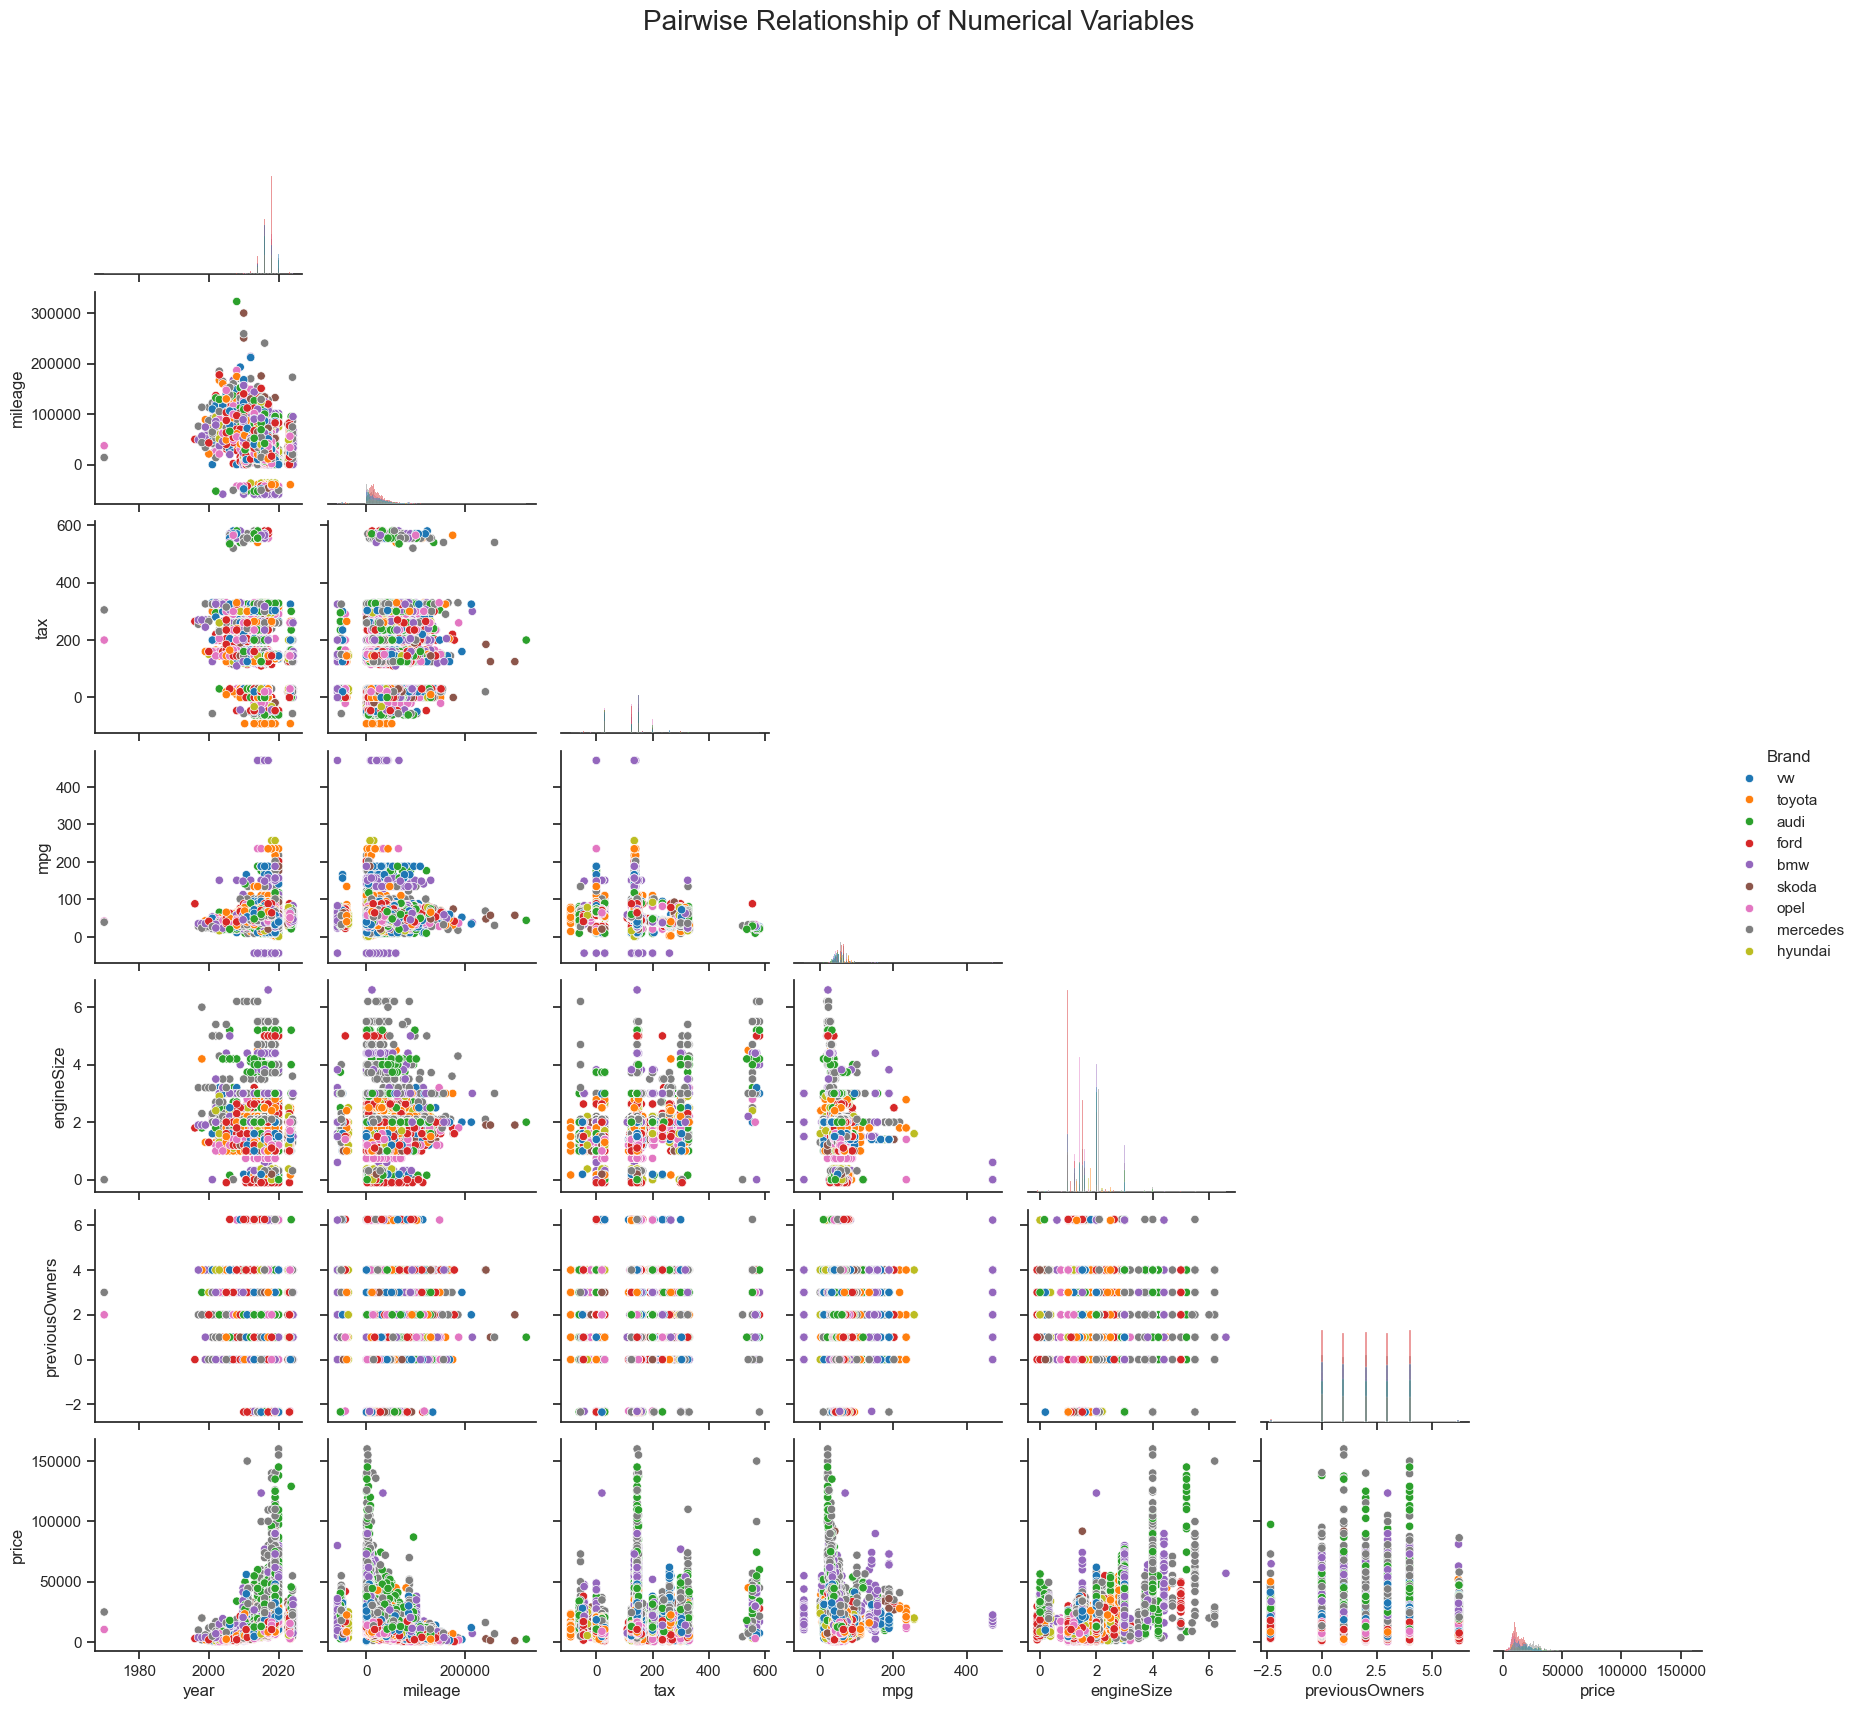

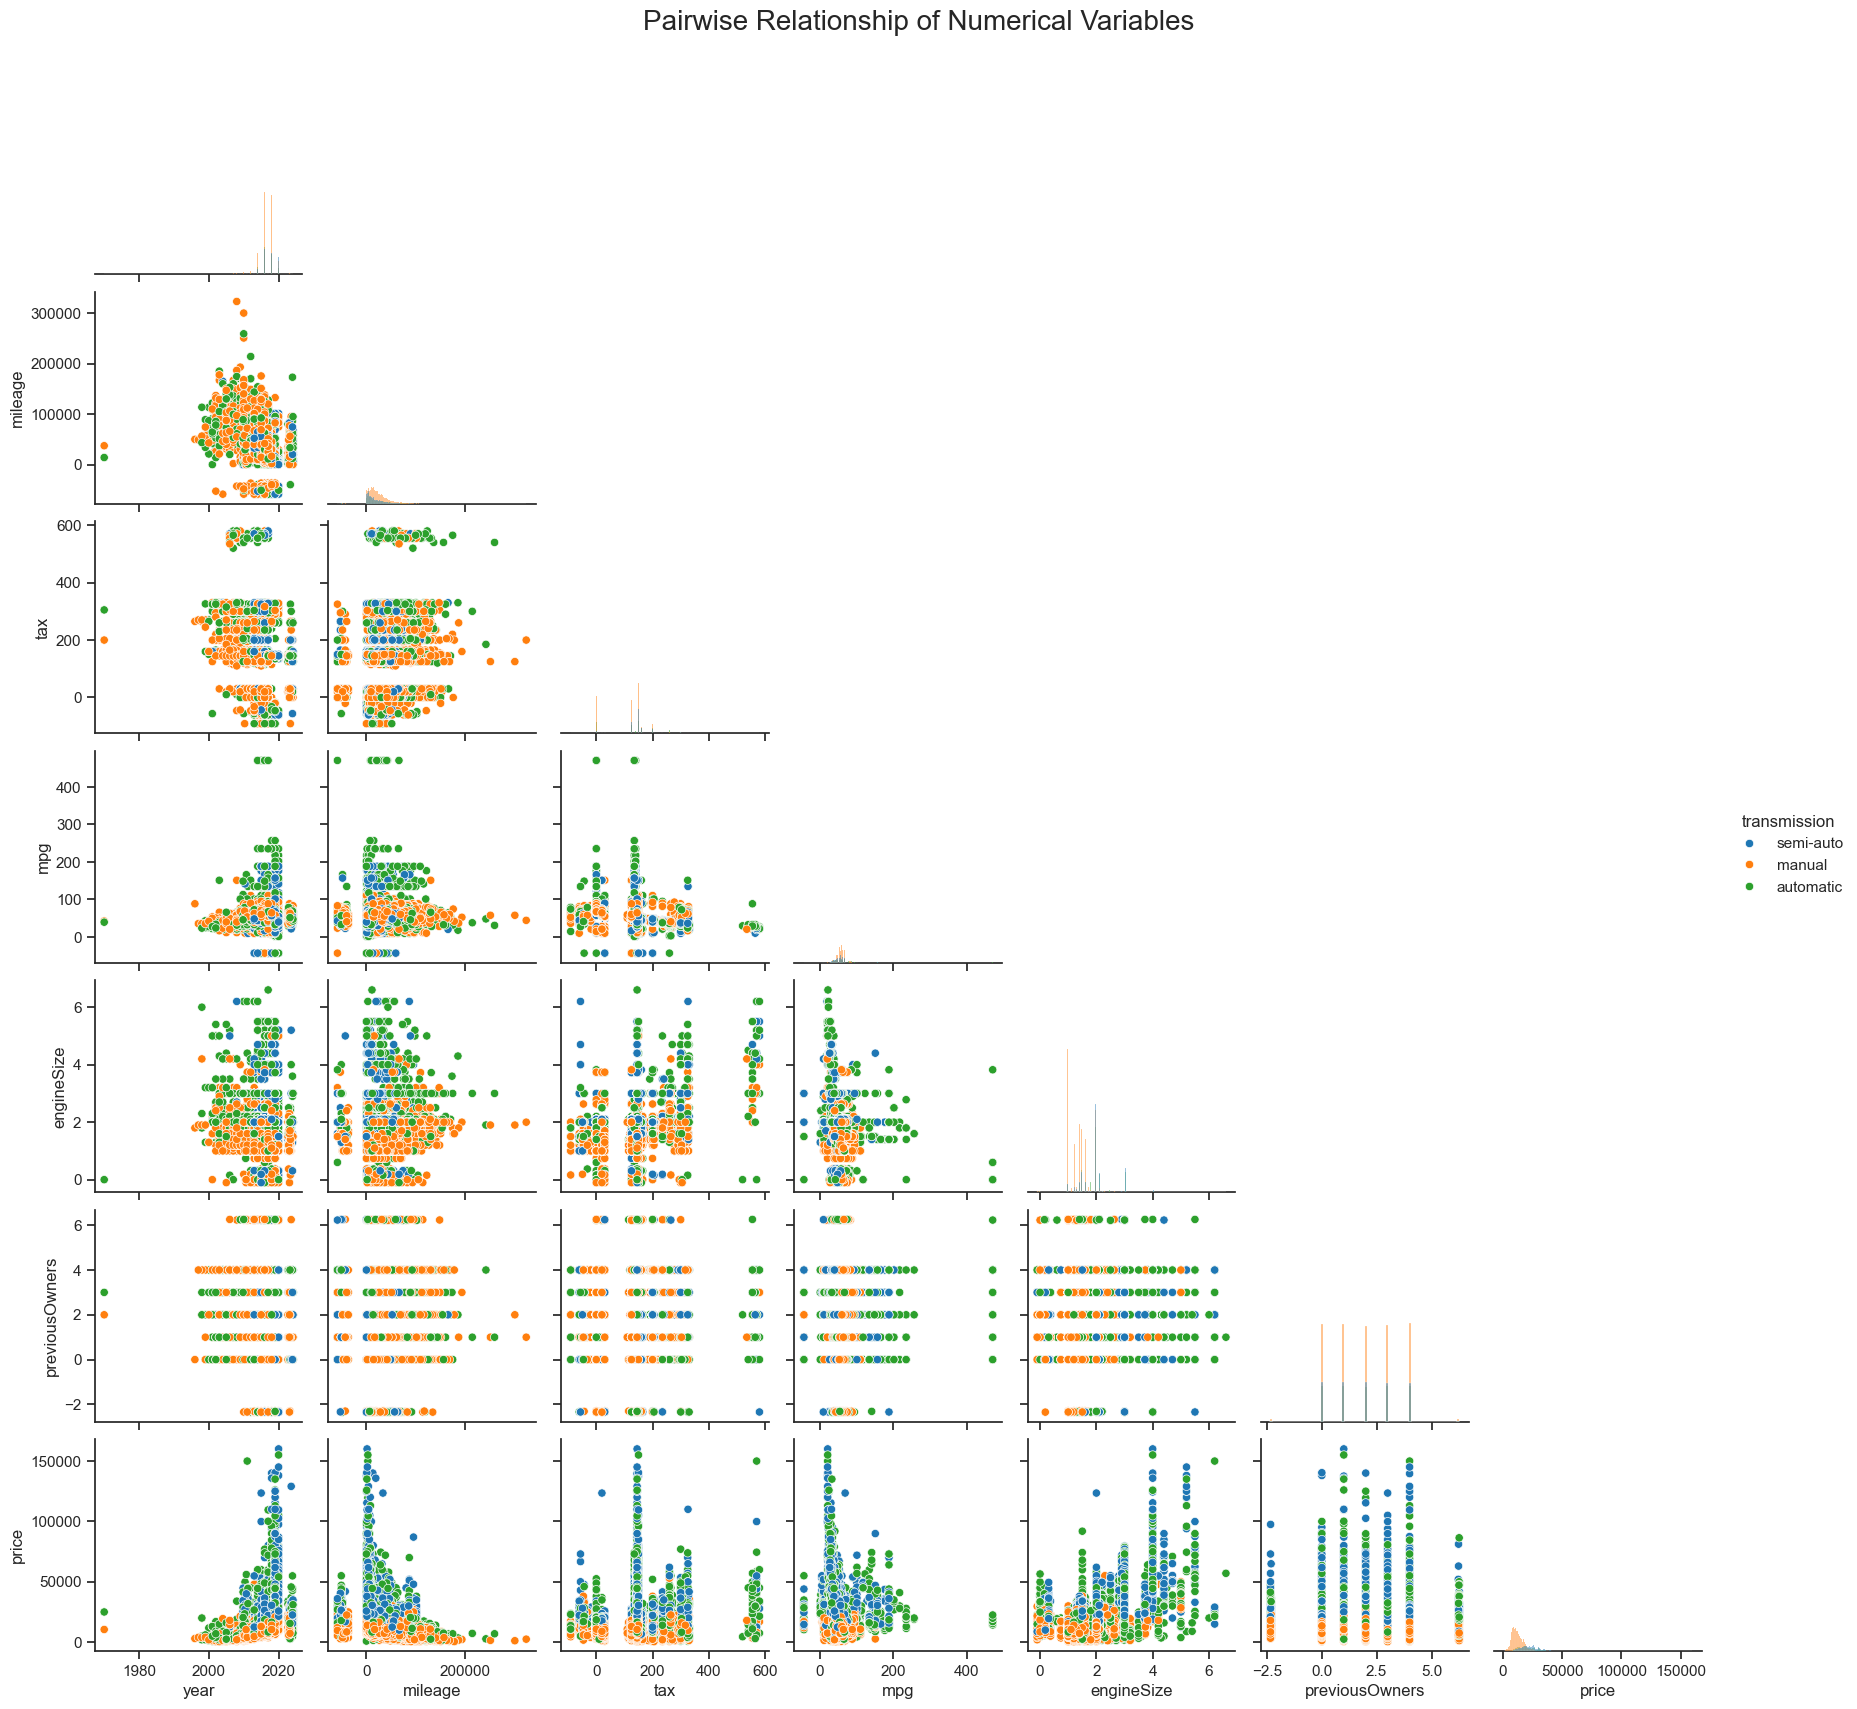

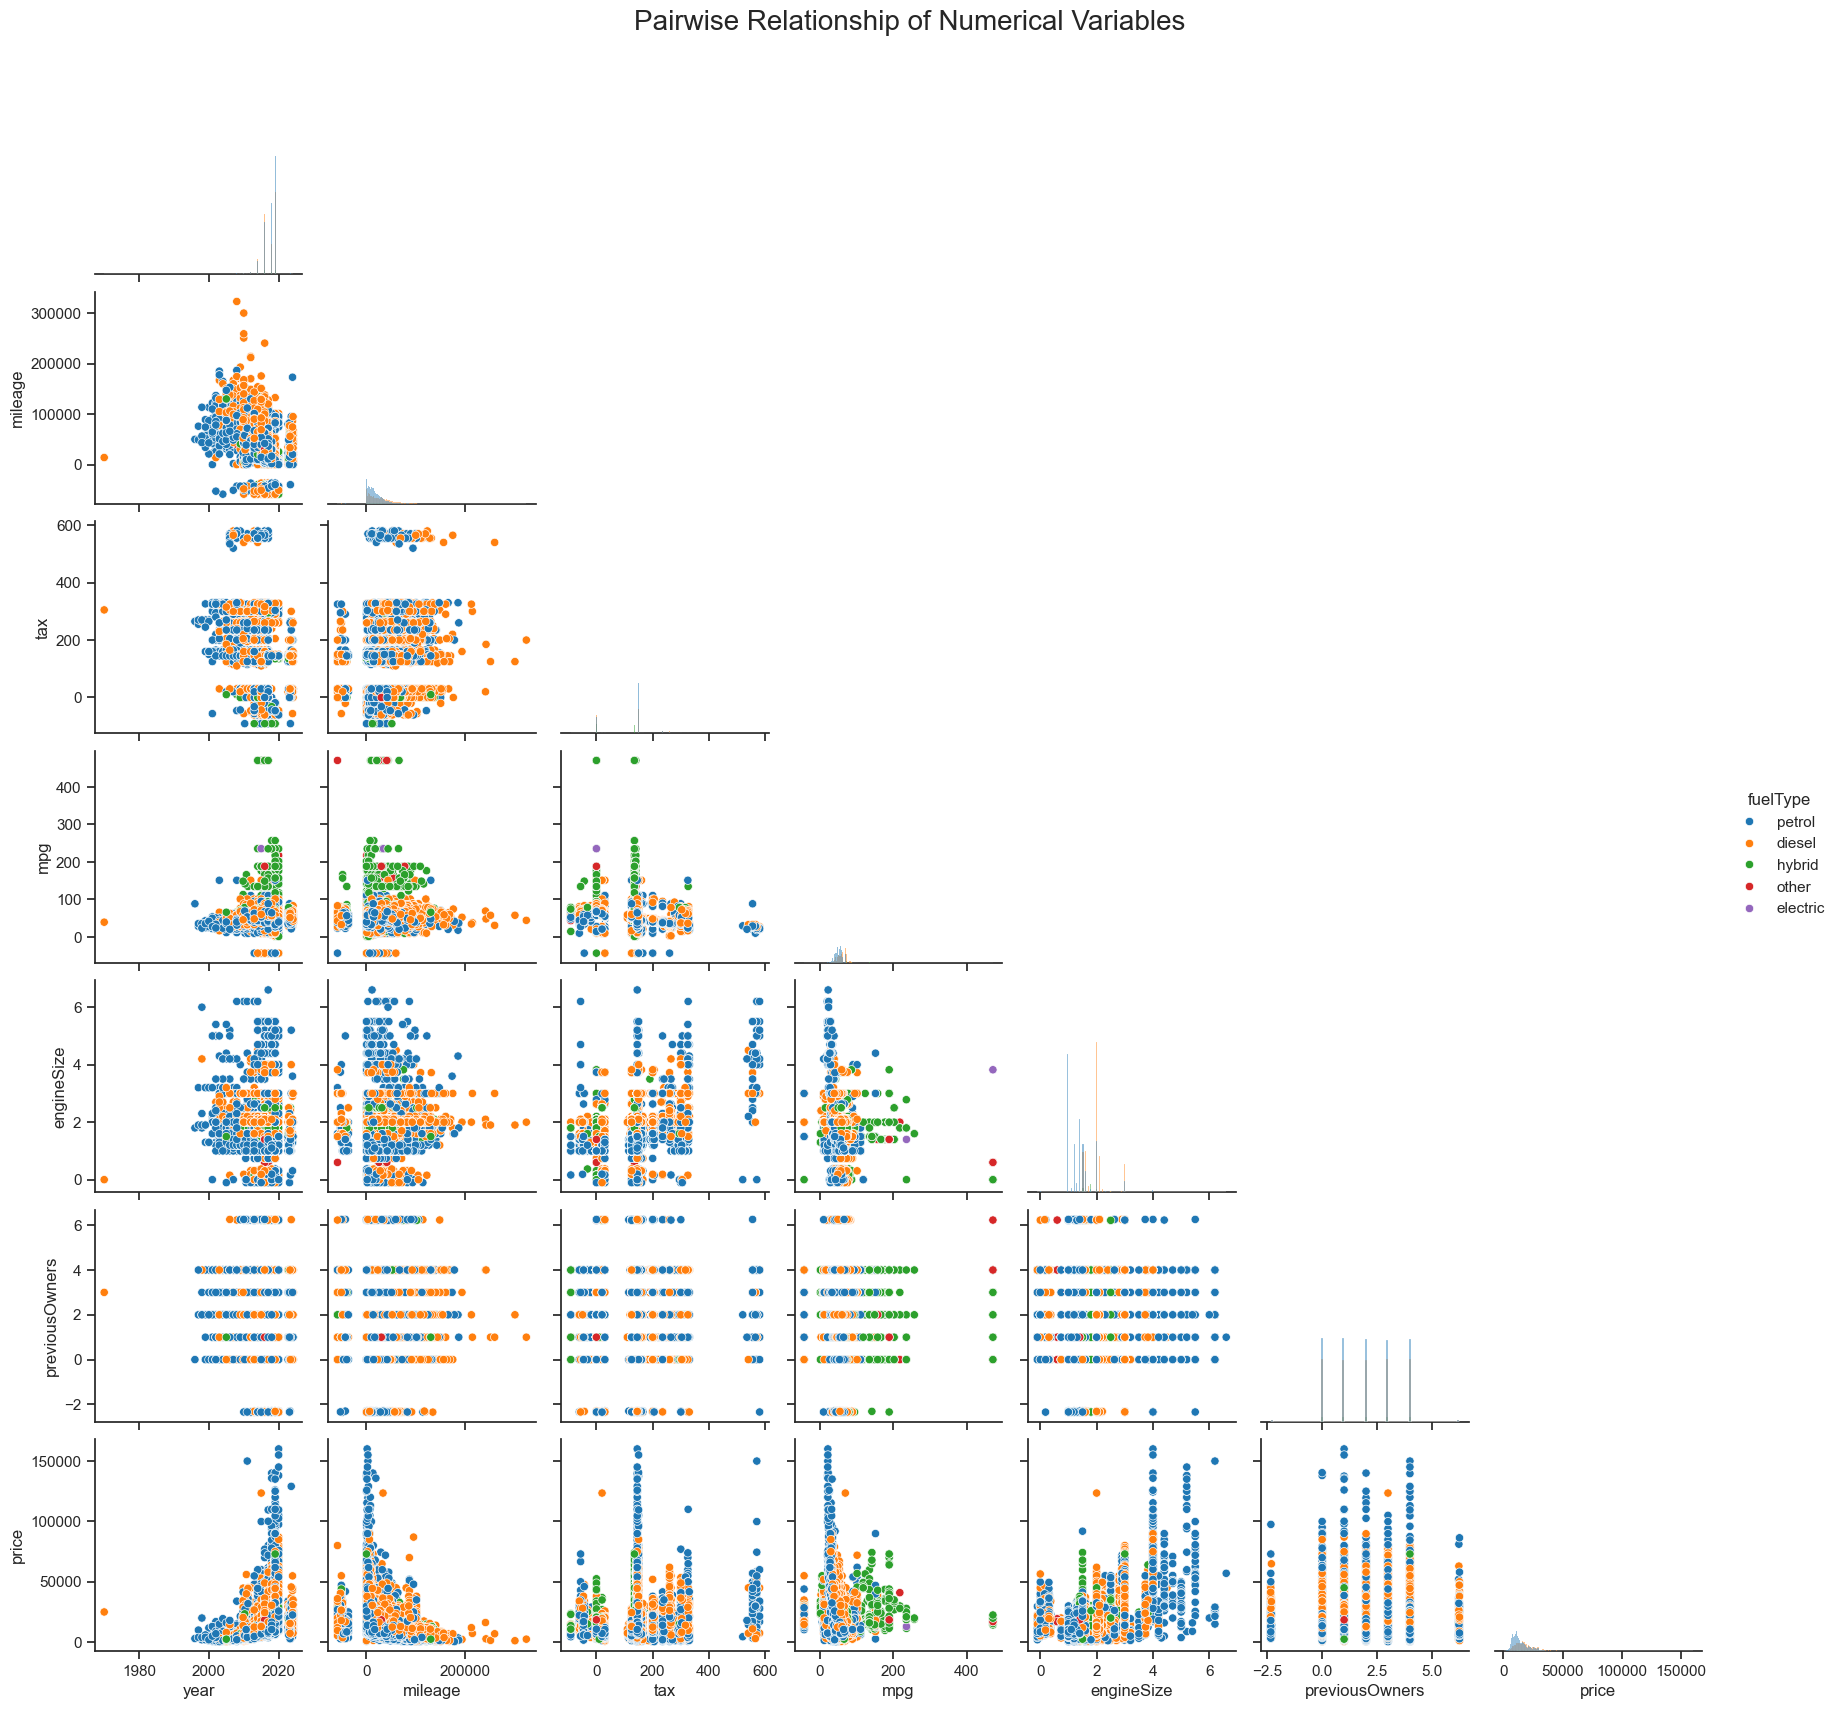

In [28]:
for categories in categorical_columns:
    sns.pairplot(
        df_cars4you_train[numerical_columns +[categories]], 
        diag_kind="hist", 
        hue= categories,
        corner=True
        )

    plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize=20)
    plt.subplots_adjust(top=0.95)
    plt.show()

<a class="anchor" id="21-bullet">    </a>
### Conclusions
[Back to Index](#toc)

#### **Descriptive Statistics Summary and Feature Analysis**

**1. Year**
- The **average manufacturing year** is approximately **2017**, with most vehicles produced between **2016 and 2019**.  
- The **minimum year (1970)** and **maximum (2024)** indicate a few **outliers or invalid entries** (e.g., future models).  
- A **low standard deviation (2.21)** shows that most cars are **recent models**.

---

**2. Price**
- The **mean price** is around **£16,882**, with prices ranging from **£450 to £159,999**.  
- The **high standard deviation (≈£9,737)** suggests **large variability** in price due to different brands, models, and specifications.  
- The **interquartile range (£10,200–£20,950)** reflects **mid-range car prices**.

---

**3. Mileage**
- The **average mileage** is **23,004 miles**, representing **lightly used cars**.  
- The **minimum value (-58,540)** is **invalid** and signals **data entry issues**.  
- Most vehicles fall between **7,423 and 32,427 miles**, which is reasonable for used vehicles.

---

**4. Tax**
- The **mean tax** is **£120.33**, and most cars are taxed between **£125 and £145**.  
- The **negative minimum (-91.12)** is **unrealistic**, indicating **erroneous records**.  
- The majority align with **standard UK vehicle tax bands**.

---

**5. MPG (Miles per Gallon)**
- The **average fuel efficiency** is **55.15 mpg**, suggesting **fuel-efficient vehicles** dominate the dataset.  
- Extreme values (from **−43.42 to 470.8 mpg**) are **outliers or errors**.  
- The middle range (46–63 mpg) appears **realistic for modern vehicles**.

---

**6. Engine Size**
- The **mean engine size** is **1.66L**, with most cars between **1.2L and 2.0L**.  
- The **minimum value (−0.10L)** is **invalid**, requiring correction.  
- A few vehicles with engines up to **6.6L** indicate the presence of **high-performance or luxury models**.

---

**7. Previous Owners**
- On average, vehicles have **about 2 previous owners**.  
- The **typical range (1–3 owners)** reflects **used cars**.  
- Negative and fractional values (e.g., **−2.35, 6.26**) are **data anomalies** that should be cleaned.

---

**8. Has Damage**
- All values are **0**, indicating **no recorded damage** for any vehicle.  
- This may mean cars are undamaged or that **damage data was not collected**.

---

**Overall Conclusion**
The dataset mostly contains **recent used cars (2016–2019)** that are **fuel-efficient, moderately priced,** and have **reasonable mileage**.  
However, several features (**mileage, tax, mpg, engine size, previous owners**) include **negative or implausible values**, signaling a need for **data cleaning and validation** before deeper analysis or model development.

### EDA Conclusions

**Categorical Features**

+ Brand: There are 9 categories, with the most common being Ford (16,063 occurrences), followed by Mercedes, Volkswagen, Opel, BMW, Audi, Toyota, Škoda, and Hyundai. This feature has too many missing values that are difficult to impute accurately, so additional cleaning or grouping may be necessary.

+ Model: Contains 296 different categories. Given the large number of unique values, we will exclude this variable from modeling and visualization to avoid unnecessary complexity.

+ Transmission: Includes 3 categories, with manual being the most common (41,627 occurrences), followed by semi-automatic and automatic.

+ Fuel Type: Contains 5 categories. The most common is petrol (41,181 occurrences), followed by diesel, with smaller proportions of hybrid, electric, and other vehicles.

+ There is a clear relationship between brand, fuel type, and transmission, reflecting distinct preferences across manufacturers. Manual cars are predominantly petrol, while automatic and semi-automatic vehicles are more often diesel or hybrid, with alternative fuel types being almost exclusively automatic.

**Numerical Features**

+ Year: The minimum registered year is 1970, and some cars are incorrectly recorded with years after 2020. Since this dataset represents data from 2020, these unrealistic values will be removed to avoid data leakage. The distribution is left-skewed, with most cars registered in 2020.

+ Mileage: Some cars have negative mileage, which will be corrected. A few entries have zero mileage, likely representing new cars. The variable is right-skewed, with only a small number of cars exceeding 100,000 miles.

+ Tax: Several records contain negative tax values, which will be fixed. Most cars are concentrated around £140, though a few have unusually high values.

+ MPG (Miles per Gallon): The average fuel efficiency is around 55 mpg. Some negative and extreme outlier values are present and will need to be treated.

+ Engine Size: This variable contains errors as well — engine sizes below 1L are unrealistic, and a few extremely large values likely correspond to supercars or incorrect entries.

+ Previous Owners: The distribution appears roughly uniform, but some records have negative values, which are invalid and will be corrected.

+ Price: The target variable (price) shows a right-skewed distribution with several extreme high-value outliers, which is expected for car prices.

**Combination of Features**

+ No features show a strong linear correlation (absolute correlation > 0.7). However, most numerical variables exhibit some relationship with the target variable (price), except for previousOwners, which seems to have little direct impact. We will still retain this variable, as it may contribute useful interactions when combined with others.

+ Brand does not form any meaningful divisions in the numerical variables.

+ Transmission establishes distinct groups: manual cars are typically cheaper, while automatic and semi-automatic vehicles are similarly priced but generally higher than manual ones. Automatic cars also tend to have higher MPG, larger engine sizes, and higher taxes, which aligns with expectations.

+ Fuel Type further differentiates vehicles: cars with ‘other’, ‘hybrid’, or ‘electric’ fuel types achieve the highest MPG. Petrol cars cover the widest range of prices and often have larger engine sizes.

<a class="anchor" id="3-bullet">    </a>
# Data Preparation:
[Back to Index](#toc)

In this phase, we will handle outliers, split the data into training and validation sets, encode and transform the variables, and treat missing values to prepare the dataset for modeling.

<a class="anchor" id="31-bullet">    </a>
### Outliers and Inconsistencies
[Back to Index](#toc)

We are going to fix all negative values and the wrong size of the engine (< 1, we are going to put as 0.9), and year (> 2020, is going to be removed). We are not going to remove outliers, what we will do instead is use a robust scaler.

In [19]:
# Year: keep between until 2020
df_cars4you_train['year'] = df_cars4you_train['year'].round().astype('Int64')
df_cars4you_train = df_cars4you_train[~(df_cars4you_train['year'] > 2020)]

# Mileage: negatives values to positive
df_cars4you_train['mileage'] = pd.to_numeric(df_cars4you_train['mileage'], errors='coerce').abs()

# Tax: negatives values to positive
df_cars4you_train['tax'] = pd.to_numeric(df_cars4you_train['tax'], errors='coerce').abs()

# Mpg: negatives values to positive
df_cars4you_train['mpg'] = pd.to_numeric(df_cars4you_train['mpg'], errors='coerce').abs()

# Engine size: lower limit of 0.9 (minimum possible value)
df_cars4you_train['engineSize'] = pd.to_numeric(df_cars4you_train['engineSize'], errors='coerce').abs()
df_cars4you_train.loc[df_cars4you_train['engineSize'] < 0.9, 'engineSize'] = 0.9

# Previous owners: absolute values
df_cars4you_train['previousOwners'] = pd.to_numeric(df_cars4you_train['previousOwners'], errors='coerce').abs()
df_cars4you_train['previousOwners'] = df_cars4you_train['previousOwners'].round().astype('Int64')

df_cars4you_train.shape

(74124, 11)

In [20]:
q1 = df_cars4you_train[numerical_columns].quantile(0.25)
q3 = df_cars4you_train[numerical_columns].quantile(0.75)
iqr = q3 - q1
lower_lim = q1 - (iqr * 3)
upper_lim = q3 + (iqr * 3)

filters_iqr_all = df_cars4you_train[numerical_columns[:-1]].apply(
    lambda col: col.between(lower_lim[col.name], upper_lim[col.name], inclusive='neither')
).all(axis=1)


df_cars4you_NO_outliers = df_cars4you_train[filters_iqr_all]

print('Percentage of data kept after removing outliers:', 100*(np.round(df_cars4you_NO_outliers.shape[0] / df_cars4you_train.shape[0], 4)))

Percentage of data kept after removing outliers: 60.6


No removal of outrliers since if we use iqr we will be removing almost half if we follow the formula (1-3)*3 (extreme outliers).

In [21]:
df_cars4you_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74124 entries, 69512 to 15795
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           72645 non-null  object 
 1   model           72649 non-null  object 
 2   year            74124 non-null  Int64  
 3   price           74124 non-null  int64  
 4   transmission    71906 non-null  object 
 5   mileage         72688 non-null  float64
 6   fuelType        72654 non-null  object 
 7   tax             66421 non-null  float64
 8   mpg             66397 non-null  float64
 9   engineSize      72637 non-null  float64
 10  previousOwners  72612 non-null  Int64  
dtypes: Int64(2), float64(4), int64(1), object(4)
memory usage: 6.9+ MB


After removing the invalid car records based on the year variable, we now have 74,124 observations, meaning that 1,849 records were deleted — approximately 2.4% of the total dataset.
Lest see the misisng values, and distrbibution of our data, after removing these obervsations.

<a class="anchor" id="33-bullet">    </a>
### Imputation:
[Back to Index](#toc)

We will need to impute missing values for the following variables:

+ Categorical: transmission, fuelType.

+ Numeric: mileage, tax, mpg, engineSize, previousOwners

<a class="anchor" id="331-bullet">    </a>
#### Categorical Fetures Imputation
[Back to Index](#toc)

For the missing values in categorical features, we will impute them using the mode of each variable.

In [22]:
#filling with mode

#store mode of training data in a variable
mode_to_fill_transmission = df_cars4you_train['transmission'].mode()[0]
mode_to_fill_fueltype = df_cars4you_train['fuelType'].mode()[0]

# fill on df_cars4you_train
df_cars4you_train['transmission'].fillna(mode_to_fill_transmission, inplace=True)
df_cars4you_train['fuelType'].fillna(mode_to_fill_fueltype, inplace=True)

lest see the brand and the model variables

In [23]:
df_complete = df_cars4you_train.dropna(subset=['Brand', 'model'])

# Now, we group by 'model' and count the number of unique 'brands' for each
model_to_brand_counts = df_complete.groupby('model')['Brand'].nunique()

# Get a list of any models that map to MORE than one brand
inconsistent_models = model_to_brand_counts[model_to_brand_counts > 1]

inconsistent_models

model
amarok        2
arteon        2
caddymaxi     2
california    2
caravelle     2
cc            2
gol           2
golf          2
golfsv        2
i3            2
passat        2
polo          2
scirocco      2
sharan        2
shuttle       2
t-cros        2
t-cross       2
t-roc         2
tiguan        2
touareg       2
touran        2
u             2
up            2
Name: Brand, dtype: int64

In [24]:
df_cars4you_train.groupby('Brand')['model'].nunique()

Brand
audi        29
bmw         58
ford        36
hyundai     24
mercedes    41
opel        34
skoda       24
toyota      28
vw          45
Name: model, dtype: int64

we conclude 2 things:

1- we have to many models by brand, and many models overall, so we will not used the model of the car.

2- since we have only few rows with missing brand we are going to drop this missing values, to later use the brand of the car to create one model per brand.

In [25]:
df_cars4you_train.drop(['model'], axis=1, inplace= True)
df_cars4you_train.dropna(subset=['Brand'], inplace = True)

In [26]:
df_cars4you_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72645 entries, 69512 to 15795
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           72645 non-null  object 
 1   year            72645 non-null  Int64  
 2   price           72645 non-null  int64  
 3   transmission    72645 non-null  object 
 4   mileage         71233 non-null  float64
 5   fuelType        72645 non-null  object 
 6   tax             65106 non-null  float64
 7   mpg             65080 non-null  float64
 8   engineSize      71192 non-null  float64
 9   previousOwners  71160 non-null  Int64  
dtypes: Int64(2), float64(4), int64(1), object(3)
memory usage: 6.2+ MB


In [27]:
(75973 - 72645) * 100 / 75973
# number of rows removed and to use

4.380503599963145

<a class="anchor" id="332-bullet">    </a>
#### Encoding
[Back to Index](#toc)

We need to encode the categorical variables and perform some feature engineering to create more meaningful variables. Specifically, we will:

+ Simplify fuelType to three categories: petrol, diesel, and other. The other category will combine hybrid, electric, and other fuels, as their behavior is similar. These will be encoded as dummy variables using n–1 dummies to avoid multicollinearity.

+ Encode transmission as dummy variables using n–1 categories.

+ Change the years, to Years_old: will be the number of years of the car with the 'Acutual year', since this data came from 2020 and the prices were at that time, we are going to use as actual year 2020 the next year, but for our test set we will use our current year 2025 (year when we will want to use our model).

In [28]:
df_cars4you_train_encoded = df_cars4you_train.copy()

# Years_old
df_cars4you_train_encoded['Years_old'] = 2021 - df_cars4you_train_encoded['year']
df_cars4you_train_encoded.drop('year', inplace = True, axis = 1)

# Only 3 options on fueltype: petrol, diesel and other
df_cars4you_train_encoded.loc[df_cars4you_train_encoded['fuelType'].isin(['electric', 'hybrid']), 'fuelType'] = 'other'

# Dummies for categorical variables
df_cars4you_train_encoded = pd.get_dummies(df_cars4you_train_encoded, columns=['transmission', 'fuelType'], drop_first=True, dtype= int)
dummy_columns_train = df_cars4you_train_encoded.columns

In [29]:
df_cars4you_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72645 entries, 69512 to 15795
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Brand                   72645 non-null  object 
 1   price                   72645 non-null  int64  
 2   mileage                 71233 non-null  float64
 3   tax                     65106 non-null  float64
 4   mpg                     65080 non-null  float64
 5   engineSize              71192 non-null  float64
 6   previousOwners          71160 non-null  Int64  
 7   Years_old               72645 non-null  Int64  
 8   transmission_manual     72645 non-null  int64  
 9   transmission_semi-auto  72645 non-null  int64  
 10  fuelType_other          72645 non-null  int64  
 11  fuelType_petrol         72645 non-null  int64  
dtypes: Int64(2), float64(4), int64(5), object(1)
memory usage: 7.3+ MB


Dummy features:
we have for the transmision: manual and semi-auto, when these 2 are 0 them is automatic.
we have for the fueltype: other and petrol, when these 2 are 0 them is diesel.

<a class="anchor" id="333-bullet">    </a>
#### Numerical Fetures Imputation
[Back to Index](#toc)

Next, we will perform imputation for the numerical features. Before doing so, we will scale the values (triying different scalears, minmax(0:1, -1:1), robust scalar, standar scalar), as the KNN imputer relies on distances to find the nearest neighbors. Scaling ensures that all features contribute equally when identifying the most similar observations to fill the missing values.

We will test the best parameters for our KNN imputer. Specifically, we will evaluate the number of neighbors (n_neighbors) from 7 to 15 and test the two possible weight types: uniform and distance-weighted. We will then assess the imputation performance using two different types of models and determine the optimal parameters for imputing the missing values.

In [31]:
cv_method = KFold(n_splits= 5, random_state = 22, shuffle= True)

X_encoded = df_cars4you_train_encoded.drop(['Brand','price'], axis=1)
Y = df_cars4you_train_encoded['price']

In [63]:
# Define the parameters to test
param_grid = {'n_neighbors': list(range(7, 12)),
              'distance': ['uniform', 'distance'],
              'scalar': [RobustScaler(), MinMaxScaler(), MinMaxScaler(feature_range = (-1,1)), StandardScaler()]}

grid = ParameterGrid(param_grid)

# Create dictionaries to save the scores
dic_train_score_imputer = {}
dic_val_score_imputer = {}

In [ ]:
# aprox 8min, total 5h30min
for params in tqdm(grid):
    avg_scores(X = X_encoded,
               y = Y,
               CV = cv_method,
               imputer = KNNImputer(n_neighbors=params['n_neighbors'], weights=params['distance']),
               scalar = params['scalar'],
               model = LinearRegression(),
               score_train_dic = dic_train_score_imputer,
               score_val_dic = dic_val_score_imputer,
               dic_key = ('LR', str(params['scalar']) ,str(params['n_neighbors']), params['distance']))


In [ ]:
for params in tqdm(grid):
    avg_scores(X = X_encoded,
               y = Y,
               CV = cv_method,
               imputer = KNNImputer(n_neighbors=params['n_neighbors'], weights=params['distance']),
               scalar = params['scalar'],
               model = KNeighborsRegressor(n_neighbors=8, weights='uniform', n_jobs=-1),
               score_train_dic = dic_train_score_imputer,
               score_val_dic = dic_val_score_imputer,
               dic_key = ('KNN', str(params['scalar']) ,str(params['n_neighbors']), params['distance']))


In [ ]:
for params in tqdm(grid):
    avg_scores(X = X_encoded,
               y = Y,
               CV = cv_method,
               imputer = KNNImputer(n_neighbors=params['n_neighbors'], weights=params['distance']),
               scalar = params['scalar'],
               model = DecisionTreeRegressor(criterion='absolute_error', max_depth=7, min_samples_split=500),
               score_train_dic = dic_train_score_imputer,
               score_val_dic = dic_val_score_imputer,
               dic_key = ('DT', str(params['scalar']) ,str(params['n_neighbors']), params['distance']))


In [ ]:
dic_val_score_imputer = dict(sorted(
    dic_val_score_imputer.items(), 
    key=lambda item: item[1][0], 
    reverse=True 
))

dic_train_score_imputer = {key: dic_train_score_imputer[key] for key in dic_val_score_imputer}

In [55]:
dic_train_score_imputer

{('LR', 'RobustScaler()', '5', 'uniform'): [np.float64(3465.23),
  np.float64(7.34)],
 ('LR', 'MinMaxScaler()', '5', 'uniform'): [np.float64(3465.61),
  np.float64(7.26)]}

In [56]:
dic_val_score_imputer

{('LR', 'MinMaxScaler()', '5', 'uniform'): [np.float64(3465.97),
  np.float64(52.93)],
 ('LR', 'RobustScaler()', '5', 'uniform'): [np.float64(3465.72),
  np.float64(52.08)]}

The best parameters for both types of models were found to be 9 neighbors with uniform weights.
So our imputer will have those. And the best paramaters for the scalar among different model and imputers types is X so we will use that from now on.

The imputation was successfully completed, and there are now zero missing values in both the training and validation datasets.

<a class="anchor" id="34-bullet">    </a>
### Feature Selection
[Back to Index](#toc)

We will perform feature selection using two approaches: RFM (Recursive Feature Elimination) and Lasso regression. Based on the results from these methods, we will determine which features are most relevant and decide which to include in the final model.


<a class="anchor" id="341-bullet">    </a>
#### RFE
[Back to Index](#toc)

We will apply RFE (Recursive Feature Elimination) on the dataset to identify the features that are most important.

In [ ]:
# Create dictionaries to save the scores
dic_train_score_rfm_LR = {}
dic_val_score_rfm_LR = {}

# Test every possible number of features
for n in tqdm(range(1, X_encoded.shape[1] + 1)):
    # use avg_scores with model rfe
    avg_scores(X = X_encoded,
               y = Y,
               CV = cv_method,
               imputer = KNNImputer(), #Write best n_neighbors=, weights=)
               scalar = 1,# Write the best scalar
               model = RFE(LinearRegression(), n_features_to_select=n),
               score_train_dic = dic_train_score_rfm_LR,
               score_val_dic = dic_val_score_rfm_LR,
               dic_key = n)

Optimum number of features: 9
Score with 9 features: 3440.7632


In [ ]:
RFM_Feature_visualization(X_encoded, dic_train_score_rfm_LR, dic_val_score_rfm_LR)

In [ ]:
# Create dictionaries to save the scores
dic_train_score_rfm_KNN = {}
dic_val_score_rfm_KNN = {}

# Test every possible number of features
for n in tqdm(range(1, X_encoded.shape[1] + 1)):
    # use avg_scores with model rfe
    avg_scores(X = X_encoded,
               y = Y,
               CV = cv_method,
               imputer = KNNImputer(), #Write best n_neighbors=, weights=)
               scalar = 1,# Write the best scalar
               model = RFE(KNeighborsRegressor(n_neighbors=8, weights='uniform', n_jobs=-1), n_features_to_select=n),
               score_train_dic = dic_train_score_rfm_KNN,
               score_val_dic = dic_val_score_rfm_KNN,
               dic_key = n)

In [ ]:
RFM_Feature_visualization(X_encoded, dic_train_score_rfm_KNN, dic_val_score_rfm_KNN)

In [ ]:
# Create dictionaries to save the scores
dic_train_score_rfm_DT = {}
dic_val_score_rfm_DT = {}

# Test every possible number of features
for n in tqdm(range(1, X_encoded.shape[1] + 1)):
    # use avg_scores with model rfe
    avg_scores(X = X_encoded,
               y = Y,
               CV = cv_method,
               imputer = KNNImputer(), #Write best n_neighbors=, weights=)
               scalar = 1,# Write the best scalar
               model = RFE(DecisionTreeRegressor(criterion='absolute_error', max_depth=7, min_samples_split=500), n_features_to_select=n),
               score_train_dic = dic_train_score_rfm_DT,
               score_val_dic = dic_val_score_rfm_LR,
               dic_key = n)

In [ ]:
RFM_Feature_visualization(X_encoded, dic_train_score_rfm_DT, dic_val_score_rfm_DT)

In [32]:
X_train_encoded_HO, X_val_encoded_HO, y_train_HO, y_val_HO = train_test_split(X_encoded, Y, 
                                                                              test_size = 0.2, 
                                                                              random_state = 0,
                                                                              shuffle = True)

In [33]:
scaler_HO = RobustScaler()
X_train_encoded_scaled_HO = scaler_HO.fit_transform(X_train_encoded_HO)
X_val_encoded_scaled_HO = scaler_HO.transform(X_val_encoded_HO)

inputer_HO = KNNImputer(n_neighbors= 8, weights='uniform')

X_train_encoded_scaled_imputed_HO = inputer_HO.fit_transform(X_train_encoded_scaled_HO)
X_val_encoded_scaled_imputed_HO = inputer_HO.transform(X_val_encoded_scaled_HO)

X_train_encoded_scaled_imputed_HO = pd.DataFrame(X_train_encoded_scaled_imputed_HO, columns=X_train_encoded_HO.columns)
X_val_encoded_scaled_imputed_HO = pd.DataFrame(X_val_encoded_scaled_imputed_HO, columns=X_val_encoded_HO.columns)

In [ ]:
model_LR = LinearRegression()
best_n_rfm_LR = 
rfe_LR = RFE(estimator = model_LR, n_features_to_select = best_n_rfm_LR)
rfe_LR = rfe_LR.fit(X_train_encoded_scaled_imputed_HO, y_train_HO)

y_pred_train= rfe_LR.predict(X_train_encoded_scaled_imputed_HO)
train_mae_score_LR = mean_absolute_error(y_train_HO, y_pred_train)
y_pred_val= rfe_LR.predict(X_val_encoded_scaled_imputed_HO)
val_mae_score_LR = mean_absolute_error(y_val_HO, y_pred_val)

selected_features_LR = pd.Series(rfe_LR.support_, index = X_train_encoded_scaled_imputed_HO.columns)
print(f"Score with {best_n_rfm_LR} features. Train:{train_mae_score_LR}, Validation:{val_mae_score_LR}" )
selected_features_LR

In [ ]:
model_KNN = KNeighborsRegressor(n_neighbors=8, weights='uniform', n_jobs=-1)
best_n_rfm_KNN = 
rfe_KNN = RFE(estimator = model_KNN, n_features_to_select = best_n_rfm_KNN)
rfe_KNN = rfe_KNN.fit(X_train_encoded_scaled_imputed_HO, y_train_HO)

y_pred_train= rfe_KNN.predict(X_train_encoded_scaled_imputed_HO)
train_mae_score_KNN = mean_absolute_error(y_train_HO, y_pred_train)
y_pred_val= rfe_KNN.predict(X_val_encoded_scaled_imputed_HO)
val_mae_score_KNN = mean_absolute_error(y_val_HO, y_pred_val)

selected_features_KNN = pd.Series(rfe_KNN.support_, index = X_train_encoded_scaled_imputed_HO.columns)
print(f"Score with {best_n_rfm_KNN} features. Train:{train_mae_score_KNN}, Validation:{val_mae_score_KNN}" )
selected_features_KNN

In [ ]:
model_DT =DecisionTreeRegressor(criterion='absolute_error', max_depth=7, min_samples_split=500)
best_n_rfm_DT = 
rfe_DT = RFE(estimator = model_DT, n_features_to_select = best_n_rfm_DT)
rfe_DT = rfe_DT.fit(X_train_encoded_scaled_imputed_HO, y_train_HO)

y_pred_train= rfe_DT.predict(X_train_encoded_scaled_imputed_HO)
train_mae_score_DT = mean_absolute_error(y_train_HO, y_pred_train)
y_pred_val= rfe_DT.predict(X_val_encoded_scaled_imputed_HO)
val_mae_score_DT = mean_absolute_error(y_val_HO, y_pred_val)

selected_features_DT = pd.Series(rfe_DT.support_, index = X_train_encoded_scaled_imputed_HO.columns)
print(f"Score with {best_n_rfm_DT} features. Train:{train_mae_score_DT}, Validation:{val_mae_score_DT}" )
selected_features_DT

<a class="anchor" id="342-bullet">    </a>
#### Lasso
[Back to Index](#toc)

We will also use Lasso regression to perform feature selection. By analyzing the coefficients assigned by Lasso, we can identify the features that have the most impact on the target variable. This will help us determine which features to retain for our final models.

In [35]:
alphas = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
results = {}

for a in tqdm(alphas):
    model_lasso = Lasso(alpha=a, random_state=22).fit(X_train_encoded_scaled_imputed_HO, y_train_HO)
    train_mae = mean_absolute_error(y_train_HO, model_lasso.predict(X_train_encoded_scaled_imputed_HO))
    val_mae = mean_absolute_error(y_val_HO, model_lasso.predict(X_val_encoded_scaled_imputed_HO))
    # Combine Coefs and Scores into one list
    results[f'Alpha_{a}'] = [train_mae, val_mae] + list(model_lasso.coef_)

# Create DF: Index is Features + Names of the error metrics
idx = list(X_train_encoded_scaled_imputed_HO.columns) + ['TRAIN_MAE', 'VAL_MAE']
lasso_df = pd.DataFrame(results, index=idx)

lasso_df

100%|██████████| 8/8 [00:00<00:00,  8.92it/s]


,Alpha_0,Alpha_0.001,Alpha_0.005,Alpha_0.01,Alpha_0.05,Alpha_0.1,Alpha_0.5,Alpha_1
mileage,3473.751409,3473.751255,3473.750638,3473.749861,3473.743610,3473.735756,3473.672836,3473.596164
tax,3429.962019,3429.961873,3429.961292,3429.960560,3429.954680,3429.947465,3429.888922,3429.818277
mpg,-2345.687363,-2345.688216,-2345.691536,-2345.695625,-2345.727174,-2345.766729,-2346.081180,-2346.490462
engineSize,-66.854585,-66.853937,-66.851360,-66.848149,-66.822684,-66.790887,-66.539238,-66.223249
previousOwners,-791.546386,-791.543646,-791.532584,-791.518842,-791.409378,-791.274235,-790.224026,-788.926860
Years_old,7878.617553,7878.613207,7878.596049,7878.574568,7878.404063,7878.189102,7876.456107,7874.260088
transmission_manual,44.626691,44.624671,44.616592,44.606492,44.525687,44.424662,43.616099,42.605232
transmission_semi-auto,-4421.219135,-4421.217167,-4421.209399,-4421.199748,-4421.123896,-4421.028931,-4420.274763,-4419.315621
fuelType_other,-3217.381690,-3217.385337,-3217.399839,-3217.417860,-3217.559584,-3217.735900,-3219.105676,-3220.824424
fuelType_petrol,1061.601872,1061.593749,1061.561301,1061.520799,1061.198001,1060.794927,1057.589460,1053.578432


<a class="anchor" id="343-bullet">    </a>
#### Conclusion
[Back to Index](#toc)

We decided to keep all the features because the RFE results showed that the difference in MAE between using 10 and 9 (suggested) features was less than £1, indicating minimal improvement. Additionally, the Lasso coefficients for previousOwners and tax were around |60|, suggesting that these variables still contribute useful information and are not entirely irrelevant.

## Conclusion preprocesing all
Lest see how our data looks like after the transformations, best imputation and scalar.

In [ ]:
df_cars4you_train.isna().sum()

Brand             1479
model             1475
year                 0
price                0
transmission      2218
mileage           1436
fuelType          1470
tax               7703
mpg               7727
engineSize        1487
previousOwners    1512
dtype: int64

In [ ]:
df_cars4you_train.describe(include='O').T

,count,unique,top,freq
Brand,72645,9,ford,15673
model,72649,296,focus,6596
transmission,74124,3,manual,42803
fuelType,74124,5,petrol,41648


In [ ]:
df_cars4you_train.describe()

,year,price,mileage,tax,mpg,engineSize,previousOwners
count,74124.0,74124.000000,72688.000000,66421.000000,66397.000000,72637.000000,72612.0
mean,2017.066551,16882.412957,23468.745813,120.842399,55.214061,1.665787,2.014901
std,2.167627,9740.687708,21618.926075,64.592957,16.428516,0.561640,1.437366
min,1970.0,450.000000,1.000000,0.000000,1.100000,0.900000,0.0
25%,2016.0,10200.000000,7616.000000,125.000000,46.300000,1.200000,1.0
50%,2017.0,14696.500000,17537.000000,145.000000,54.300000,1.600000,2.0
75%,2019.0,20950.000000,32828.500000,145.000000,62.800000,2.000000,3.0
max,2020.0,159999.000000,323000.000000,580.000000,470.800000,6.600000,6.0


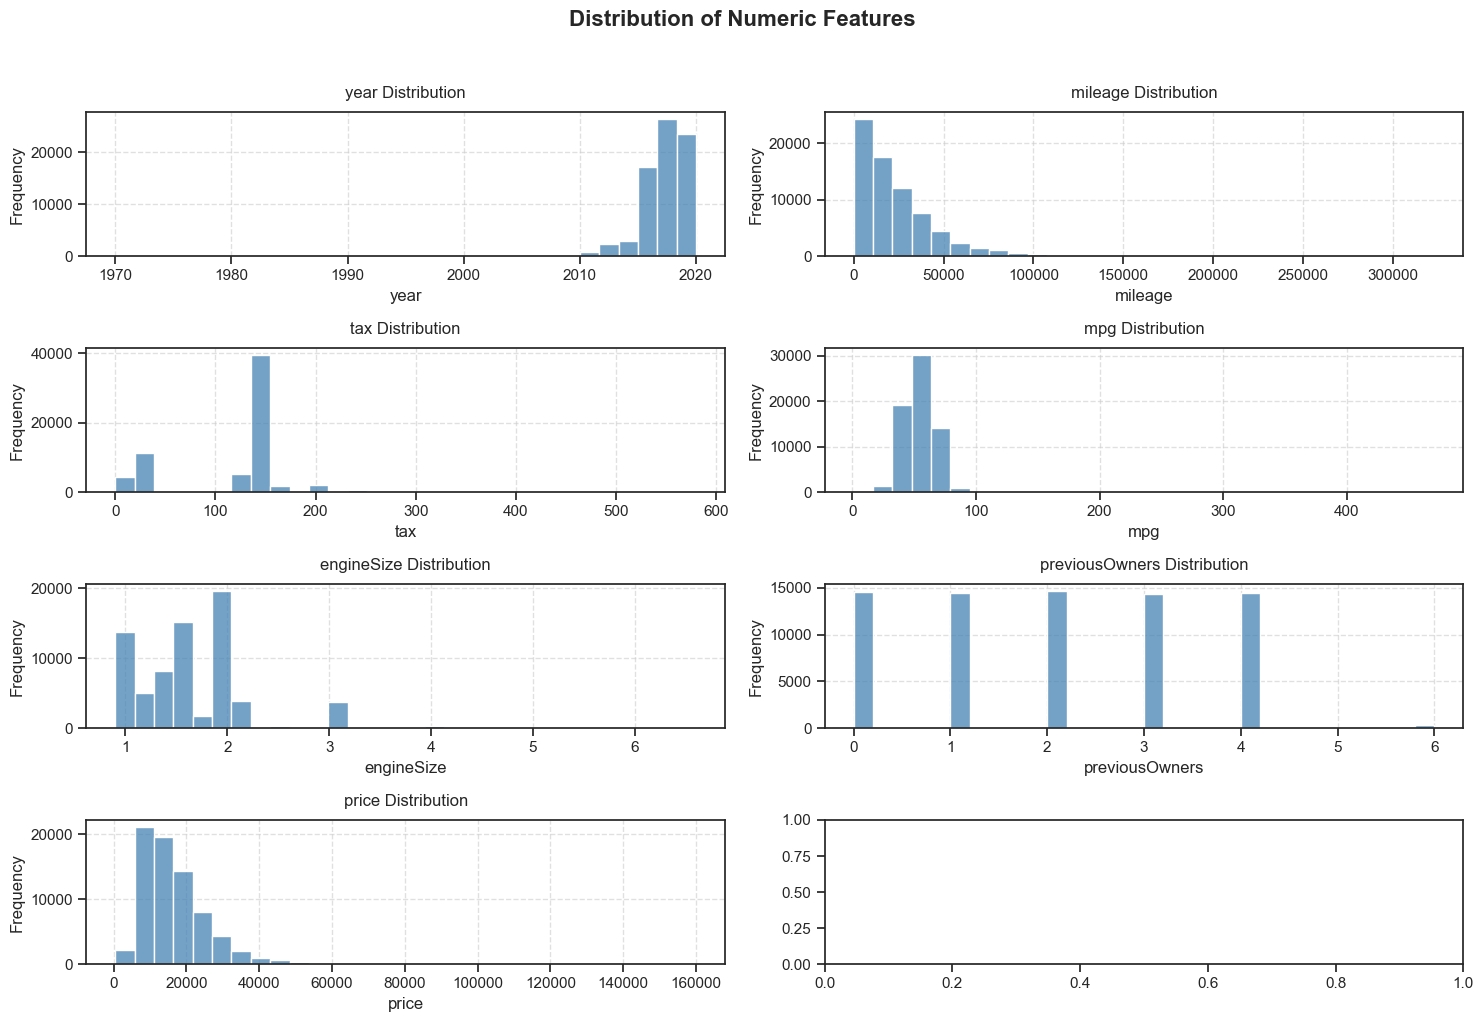

In [ ]:
sp_rows = 4
sp_cols = 2

# Create the figure
fig, axes = plt.subplots(sp_rows, sp_cols, figsize=(15, 10))
axes = axes.flatten()

# --- Plot Each Feature ---
for i, feat in enumerate(numerical_columns):
    ax = axes[i]
    
    sns.histplot(df_cars4you_train[feat].dropna(), kde=False, ax=ax, bins=30, color="steelblue")
    ax.set_xlabel(feat)
    
    # Titles & formatting
    ax.set_title(f"{feat} Distribution", fontsize=12, pad=10)
    ax.set_ylabel("Frequency")
    ax.grid(True, linestyle='--', alpha=0.6)

# --- Layout & Global Title ---
plt.suptitle("Distribution of Numeric Features", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

Now see that all the values make sence in real life.
Conclude about the variation of missing values, and distrbution before and after.

Saving into a csv for modeling

In [ ]:
# code to df-csv for modeling (only encoded, no misisng values, scalar, anything)